# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [7]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

In [3]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [4]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [5]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


<div class="span5 alert alert-success">
<p>Your answers to Q1 and Q2 here</p>
</div>

### QUESTION 1: What test is appropriate for this problem? Does the Central Limit Theorem apply?

In [6]:
# Check shape of the database
w = data[data.race=='w']
b = data[data.race=='b']
[w.shape, b.shape]

[(2435, 65), (2435, 65)]

In [39]:
#Check basic percentage of all applicants who received a call
all_calls = data['call']
all_call_rate = np.sum(all_calls) / 2435 / 2
all_call_rate

0.08049281314168377

In [14]:
# Check basic percentage of applicants in each group who received a call
[w_call, b_call] = [np.sum(w['call']) / 2435, np.sum(b['call']) / 2435]
[w_call, b_call]

[0.09650924024640657, 0.06447638603696099]

In [40]:
# Calculate standard deviation of sample
sd = all_calls.std()
sd

0.27208257

In [12]:
# Calculate standard error of sample
se = sd / (2435 ** 0.5)
se

0.005513802854918756

In [15]:
# Calculate z-score
z = (w_call - b_call) / se
z

5.8095755420181

Text(0.5,1,'Submitting identical resumes with names artificially altered to sound white or black')

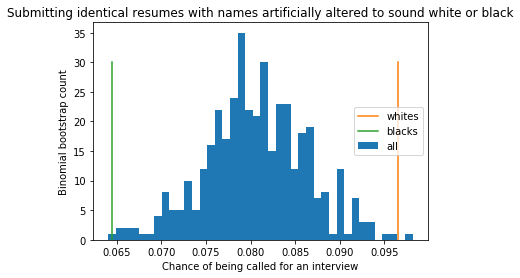

In [41]:
# Model a generic binomial distribution with average probability equal to the entire sample
# Then plot the mean call rate for the racial samples for visual comparison

bi_sample = np.random.binomial(2435, all_call_rate, 400) / 2435.0
_ = plt.hist(bi_sample, bins=40)
_ = plt.plot([w_call, w_call], [0, 30])
_ = plt.plot([b_call, b_call], [0, 30])
plt.legend(['whites', 'blacks', 'all'])
plt.xlabel('Chance of being called for an interview')
plt.ylabel('Binomial bootstrap count')
plt.title('Submitting identical resumes with names artificially altered to sound white or black')

### Answer 1
<p>There are two different tests that would be appropriate for this problem. We could either do a two-sample z-test for independence, to see if the white sample and black sample could have been plausibly drawn from the same distribution, or we could do a one-sided one-sample z-test on the black sample to see if the black sample could plausibly have been drawn from the same distribution as the entire population.</p>
<p>Either option would probably yield good results here, because the pattern of racism is so visually clear from the initial exploratory analysis, but the first option makes better use of all of the available data and has more power, so I will perform a two-sample test for independence. A z-test is more appropriate than a t-test becuase we are modeling a binomial distribution, and so the variance of the sample is an unbiased estimator of the variance of the population.</p>
<p>The Central Limit Theorem applies here because a sufficiently large sample from a binomial distribution can be safely assumed to have a normal distribution. The rule of thumb is that we should expect at least 10 successes and 10 failures. With 2345 members in the sample and a minimum success rate of 0.06, 2345 * 0.06 >> 10, so it is safe to assume normality.</p>

### Answer 2
<p>The null hypothesis is that the two samples were both drawn from the same distribution. The alternative hypothesis is that the samples were drawn from different distributions.</p>
<p><i>H0:p1=p2</i></p>
<p><i>HA:p1≠p2</i></p>

### QUESTION 3: Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

##### Margin of Error

In [47]:
# With alpha = 0.05, the margin of error in each direction is the standard error times the z-score for 97.5%.
margin = stats.norm.ppf(.975) * se
margin

0.010806855013494892

##### Confidence Interval

In [49]:
# The confidence interval is simply the range between the mean minus the margin of error and the mean plus the margin
# of error.

[all_call_rate - margin, all_call_rate + margin]

[0.06968595812818888, 0.09129966815517866]

##### P-Value

In [52]:
# The p-value that the black sample could have been drawn from the same overall distribution corresponds to its z-score.
p = stats.norm.cdf(z) 
1 - p

3.1315714466018107e-09

##### Bootstrapping

In [58]:
### In 10,000 bootstrapping experiments, not one of them returned a value as extreme as the actual sample of resumes
# with black-sounding names.

import numpy as np
bs_sample_means = np.empty(10000)
for i in range(10000):
    bs_sample = np.random.choice(all_calls, size=len(all_calls))
    bs_sample_means[i] = bs_sample.mean()
bs_error = all_call_rate - bs_sample_means
actual_error = all_call_rate - b_call
p = np.sum(bs_error < actual_error) / 10000.0
1 - p        

0.0

<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>

### QUESTION 4. Write a story describing the statistical significance in the context or the original problem.
<p>The data is very strong evidence that the perceived racial group of a name in a resume affects the likelihood that US employers will call a candidate in for an interview. The odds are less than one in one million that such an extremely racially segregated pair of samples would have been drawn from a uniform binomial distribution through chance alone. The practical impact of the racial discrimination also appears to be important. The callback rate for white names was 9.6%, compared to only 6.4% for black names. In other words, people with black names might expect to have to submit 50% more resumes to get the same number of callbacks as people with white names. This is an important burden that should be taken into account when making domestic policies.</p>
<p>One question for follow-up research is the extent to which these resumes and these employers were representative of the entire US population. According to the study sponsors, employers were only contacted in two cities (Boston and Chicago) and all jobs were for sales, administrative, and clerical jobs. Hiring managers who work in suburban or rural areas, or who live in the southern or western parts of the United States, or who hire candidates for other types of jobs, e.g., nuclear engineers, or lawyers, or doctors, or food prep workers, might have other patterns of racial discrimination. The study is also 20 years old now, and patterns of discrimination may have changed. Nevertheless, this study is strong and relevant evidence about employment discrimination in the United States.</p>

### QUESTION 5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?
<p></p>

<p> The perceived race of a candidate's name is not necessarily *the* single most important factor in callback success just because it is both statistically and practically significant. To determine which factors are most important, we can perform a multi-variable regression and examine the coefficients associated with each putatively explanatory variable.</p>

In [71]:
data['race'] = data['race'].replace('w', 1)
data['race'] = data['race'].replace('b', 0)
data['race'] = data['race'].astype('int')
data['race'].head()

0    1
1    1
2    0
3    0
4    1
Name: race, dtype: int32

In [72]:
import statsmodels.api as sm
X = data[['education', 'ofjobs', 'yearsexp', 'honors', 'volunteer', 'military', 'race']]
y = data['call']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   call   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     8.138
Date:                Mon, 21 Oct 2019   Prob (F-statistic):           6.98e-10
Time:                        16:15:48   Log-Likelihood:                -542.33
No. Observations:                4870   AIC:                             1101.
Df Residuals:                    4862   BIC:                             1153.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0524      0.022      2.367      0.018       0.009       0.096
education     -0.0029      0.006     -0.520      0.603      -0.014       0.008
ofjobs        -0.0013      0.004     -0.354      0.723      -0.008       0.006
yearsexp       0.0028      0.001      3.285      0.001       0.001       0.004
honors         0.0788      0.018      4.418      0.000       0.044       0.114
volunteer      0.0057      0.008      0.671      0.502      -0.011       0.022
military      -0.0097      0.014     -0.686      0.492      -0.038       0.018
race           0.0317      0.008      4.085      0.000       0.016       0.047
==============================================================================
Omnibus:                     2939.109   Durbin-Watson:                   1.453
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18473.773
Skew:                           3.033   Prob(JB):                         0.00
Kurtosis:                      10.365   Cond. No.                         61.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### ANSWER 5
<p> As shown above, race is not the variable with the largest coefficient. Rather, race has a coefficient of 0.317, and honors has a coefficient of 0.078. In other words, changing the name on a resume to white increases the marginal predicted chance that the resume will receive an interview by about 3%, but changing the resume's educational section so that it shows that the candidate graduated with honors increases the marignal predicted chance of an interview by about 7%. Both variables are highly statistically significant at p < 0.001.</p>
<p>Intringuingly, employers did not seem to care whether a candidate was a veteran.</p>
<p>This new information does not require *amending* the analysis, but it is an important *addition* to the analysis. Race was a very important factor in entry-level hiring in Boston and Chicago in the early 2000s, but educational honors were most likely even more important than race.</p>